In [6]:
!pip install keras==2.15.0

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import os
from PIL import Image
import itertools

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


# Preprocessing

In [9]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [10]:
df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [11]:
# Preprocessing Valid Dataset

valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [12]:
valid

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [13]:
# Preprocessing Test Dataset

test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)


In [14]:
test

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


# Image Generator

In [15]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

batch_size = 64
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


# Model Layers and Training

In [28]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras

def attention_block(input_tensor, filters):
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (1, 1), padding='same')(attn)
    attn = Activation('softmax')(attn)
    output_tensor = Multiply()([input_tensor, attn])
    return output_tensor

input_tensor = keras.Input(shape=(224, 224, 3))
x = attention_block(input_tensor, 32)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(train_gen, validation_data=valid_gen, verbose=1, epochs=10, batch_size=batch_size, callbacks=[early_stopping])

loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/10
66/66 [==============================] - 50s 669ms/step - loss: 939.4117 - accuracy: 0.8674 - val_loss: 1.1805 - val_accuracy: 0.9234
Epoch 2/10
66/66 [==============================] - 44s 662ms/step - loss: 0.4018 - accuracy: 0.9650 - val_loss: 0.6429 - val_accuracy: 0.9502
Epoch 3/10
66/66 [==============================] - 44s 665ms/step - loss: 0.1321 - accuracy: 0.9868 - val_loss: 0.6484 - val_accuracy: 0.9444
Epoch 4/10
66/66 [==============================] - 44s 663ms/step - loss: 0.0231 - accuracy: 0.9974 - val_loss: 0.5689 - val_accuracy: 0.9483
Epoch 5/10
66/66 [==============================] - 47s 717ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.5573 - val_accuracy: 0.9579
Epoch 6/10
66/66 [==============================] - 44s 665ms/step - loss: 8.9086e-04 - accuracy: 1.0000 - val_loss: 0.5170 - val_accuracy: 0.9502
Epoch 7/10
66/66 [==============================] - 45s 675ms/step - loss: 5.5793e-04 - accuracy: 1.0000 - val_loss: 0.5105 - val_accura

# Evaluation

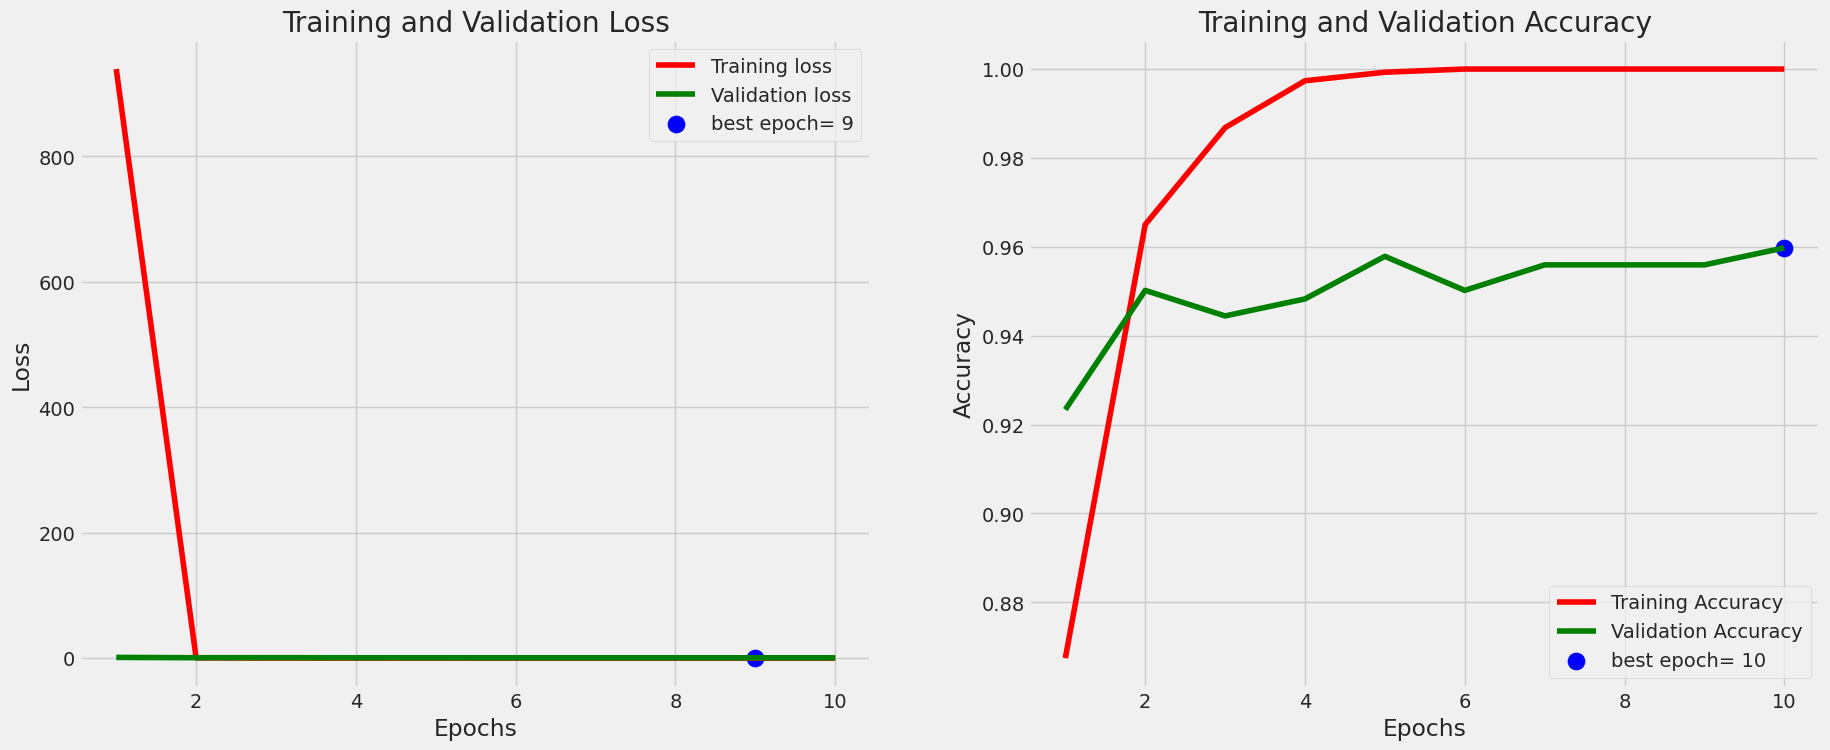

9/9 [==============================] - 5s 553ms/step - loss: 0.4521 - accuracy: 0.9559
Train Loss:  0.0002259384491480887
Train Accuracy:  1.0
--------------------
Validation Loss:  0.5098437070846558
Validation Accuracy:  0.959770143032074
--------------------
Test Loss:  0.45211687684059143
Test Accuracy:  0.9559386968612671


In [29]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 [==============================] - 5s 552ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       156
           1       0.97      0.97      0.97       366

    accuracy                           0.96       522
   macro avg       0.95      0.95      0.95       522
weighted avg       0.96      0.96      0.96       522



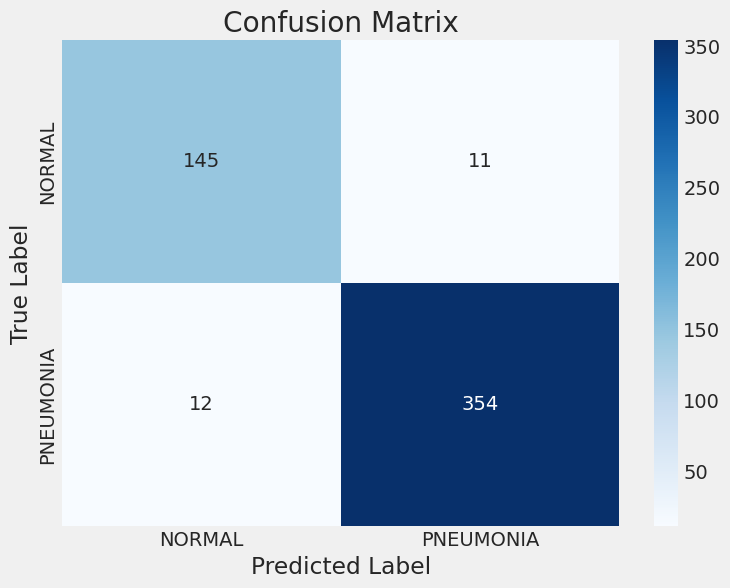

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 224, 224, 32)         896       ['input_3[0][0]']             
                                                                                                  
 activation_16 (Activation)  (None, 224, 224, 32)         0         ['conv2d_14[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 224, 224, 32)         9248      ['activation_16[0][0]']       
                                                                                            

# Saving and Inference

In [35]:
# Save the model
model.save('/kaggle/working/Pneumonia_Detection_Attention_Block.h5')

In [36]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0119-0001.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)


1/1 [==============================] - 0s 18ms/step
Predicted Class: NORMAL
Probability: 0.5568295
